# Dogecoin LSTM

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
dogecoin_csv = os.path.join(current_folder, "data","dogecoin_hourly.csv")
dogecoin_df = pd.read_csv(dogecoin_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
dogecoin_df['highLowDif'] = dogecoin_df['highPriceUsd'] - dogecoin_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
dogecoin_df['datetime'] = pd.to_datetime(dogecoin_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = dogecoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = dogecoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = dogecoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [8]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [9]:
dogecoin_df.iloc[0]

datetime                       2021-02-03 00:00:00+00:00
dogecoin_count                                       757
dogecoin_polarity                               0.181273
dogecoin_subjectivity                           0.517948
dogecoin_polarity_zeros                        0.0900342
dogecoin_subjectivity_zeros                     0.276182
openPriceUsd                                   0.0313916
closePriceUsd                                  0.0337058
highPriceUsd                                   0.0337058
lowPriceUsd                                    0.0313916
volume                                        2941705889
marketcap                                     4321287841
highLowDif                                    0.00231423
Name: 0, dtype: object

In [10]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'dogecoin_polarity', 'dogecoin_subjectivity', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [11]:
timeperiod_df.iloc[0]

dogecoin_count                 7.570000e+02
dogecoin_polarity_zeros        9.003420e-02
dogecoin_subjectivity_zeros    2.761818e-01
closePriceUsd                  3.370579e-02
highPriceUsd                   3.370579e-02
lowPriceUsd                    3.139156e-02
volume                         2.941706e+09
Name: 0, dtype: float64

In [12]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples+validation_samples, 0)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples+validation_samples, 0)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 2160th, validation: 2160th, test: 2400th
Input shape: (128, 120, 7)
Target shape: (128, 1)


In [13]:
# extracting targets from the val_dataset to plot alongside predictions
y_val = np.concatenate([y for x, y in val_dataset], axis=0)

In [14]:
# This doesn't create a full dataset between the points
# find better method if time (like below)
combined_dataset = train_dataset.concatenate(val_dataset)

In [15]:
# setting up customised test_dataset
test_data = timeperiod_df[(training_samples+validation_samples) - lookback + delay:len(timeperiod_df) - delay - 1].to_numpy()

test_targets = timeperiod_df.iloc[(training_samples+validation_samples)+ delay + delay:, timeperiod_df.columns.get_loc("closePriceUsd")]
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        test_data,
        None,
        sequence_length=lookback,
        sampling_rate=step,
        batch_size=batch_size,
    )

## LSTM models

Epoch 1/20
13/13 [==============================] - 11s 564ms/step - loss: 0.1138 - val_loss: 2.5549
Epoch 2/20
13/13 [==============================] - 6s 488ms/step - loss: 0.0184 - val_loss: 2.6613
Epoch 3/20
13/13 [==============================] - 7s 549ms/step - loss: 0.0221 - val_loss: 2.3427
Epoch 4/20
13/13 [==============================] - 7s 510ms/step - loss: 0.0182 - val_loss: 2.0353
Epoch 5/20
13/13 [==============================] - 7s 512ms/step - loss: 0.0168 - val_loss: 1.6680
Epoch 6/20
13/13 [==============================] - 7s 519ms/step - loss: 0.0159 - val_loss: 1.1995
Epoch 7/20
13/13 [==============================] - 7s 543ms/step - loss: 0.0138 - val_loss: 0.8322
Epoch 8/20
13/13 [==============================] - 8s 599ms/step - loss: 0.0134 - val_loss: 0.5213
Epoch 9/20
13/13 [==============================] - 7s 508ms/step - loss: 0.0127 - val_loss: 0.4038
Epoch 10/20
13/13 [==============================] - 6s 487ms/step - loss: 0.0110 - val_loss: 0.995

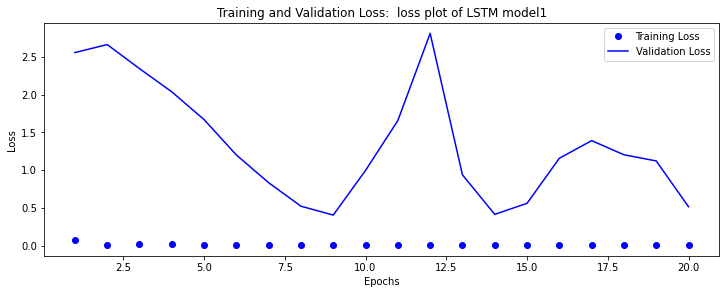

In [16]:
LSTM_model1 = models.Sequential()
LSTM_model1.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model1.add(layers.LSTM(100))


LSTM_model1.add(layers.Dense(1))

LSTM_model1.compile(optimizer=RMSprop(), loss='mse')
LSTM_model1_history = LSTM_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model1_history, "loss plot of LSTM model1")

Epoch 1/20
13/13 [==============================] - 13s 562ms/step - loss: 0.0708 - val_loss: 2.6831
Epoch 2/20
13/13 [==============================] - 7s 510ms/step - loss: 0.0211 - val_loss: 2.7211
Epoch 3/20
13/13 [==============================] - 7s 575ms/step - loss: 0.0242 - val_loss: 2.3775
Epoch 4/20
13/13 [==============================] - 7s 569ms/step - loss: 0.0200 - val_loss: 2.0664
Epoch 5/20
13/13 [==============================] - 7s 538ms/step - loss: 0.0181 - val_loss: 1.5221
Epoch 6/20
13/13 [==============================] - 7s 575ms/step - loss: 0.0157 - val_loss: 1.0387
Epoch 7/20
13/13 [==============================] - 8s 645ms/step - loss: 0.0138 - val_loss: 0.7395
Epoch 8/20
13/13 [==============================] - 7s 550ms/step - loss: 0.0129 - val_loss: 0.5444
Epoch 9/20
13/13 [==============================] - 8s 595ms/step - loss: 0.0139 - val_loss: 0.3488
Epoch 10/20
13/13 [==============================] - 8s 640ms/step - loss: 0.0101 - val_loss: 0.420

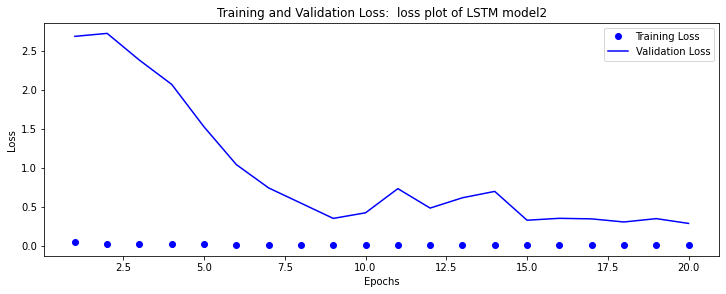

In [17]:
LSTM_model2 = models.Sequential()
LSTM_model2.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model2.add(layers.LSTM(100))


LSTM_model2.add(layers.Dense(1))

LSTM_model2.compile(optimizer=RMSprop(), loss='mse')
LSTM_model2_history = LSTM_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model2_history, "loss plot of LSTM model2")

Epoch 1/20
13/13 [==============================] - 11s 490ms/step - loss: 0.0621 - val_loss: 2.7376
Epoch 2/20
13/13 [==============================] - 6s 456ms/step - loss: 0.0268 - val_loss: 2.6275
Epoch 3/20
13/13 [==============================] - 7s 523ms/step - loss: 0.0193 - val_loss: 2.3734
Epoch 4/20
13/13 [==============================] - 7s 479ms/step - loss: 0.0154 - val_loss: 2.0526
Epoch 5/20
13/13 [==============================] - 5s 419ms/step - loss: 0.0155 - val_loss: 1.7120
Epoch 6/20
13/13 [==============================] - 8s 650ms/step - loss: 0.0129 - val_loss: 1.3663
Epoch 7/20
13/13 [==============================] - 6s 469ms/step - loss: 0.0099 - val_loss: 1.1205
Epoch 8/20
13/13 [==============================] - 6s 484ms/step - loss: 0.0125 - val_loss: 0.7614
Epoch 9/20
13/13 [==============================] - 6s 478ms/step - loss: 0.0085 - val_loss: 0.5415
Epoch 10/20
13/13 [==============================] - 6s 446ms/step - loss: 0.0157 - val_loss: 0.449

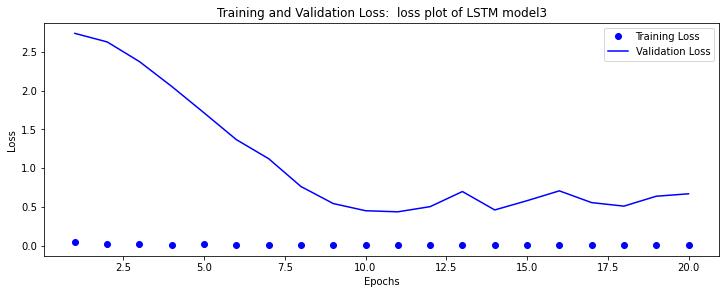

In [18]:
LSTM_model3 = models.Sequential()
LSTM_model3.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model3.add(layers.LSTM(50))


LSTM_model3.add(layers.Dense(1))

LSTM_model3.compile(optimizer=RMSprop(), loss='mse')
LSTM_model3_history = LSTM_model3.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model3_history, "loss plot of LSTM model3")

Epoch 1/20
13/13 [==============================] - 12s 555ms/step - loss: 0.0542 - val_loss: 2.5826
Epoch 2/20
13/13 [==============================] - 6s 441ms/step - loss: 0.0212 - val_loss: 2.5288
Epoch 3/20
13/13 [==============================] - 6s 506ms/step - loss: 0.0219 - val_loss: 2.3952
Epoch 4/20
13/13 [==============================] - 7s 548ms/step - loss: 0.0198 - val_loss: 1.9868
Epoch 5/20
13/13 [==============================] - 6s 446ms/step - loss: 0.0146 - val_loss: 1.8906
Epoch 6/20
13/13 [==============================] - 5s 413ms/step - loss: 0.0169 - val_loss: 1.5244
Epoch 7/20
13/13 [==============================] - 5s 384ms/step - loss: 0.0136 - val_loss: 1.2129
Epoch 8/20
13/13 [==============================] - 6s 450ms/step - loss: 0.0123 - val_loss: 1.0057
Epoch 9/20
13/13 [==============================] - 6s 446ms/step - loss: 0.0119 - val_loss: 0.6624
Epoch 10/20
13/13 [==============================] - 6s 492ms/step - loss: 0.0119 - val_loss: 0.545

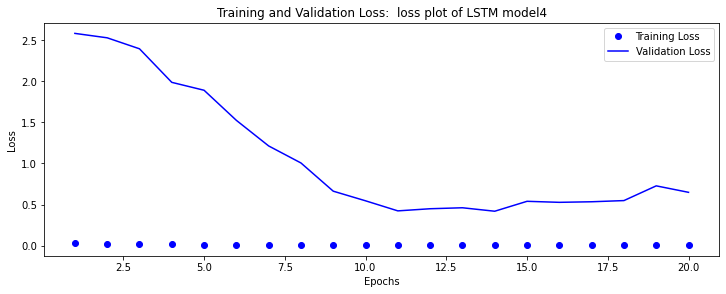

In [19]:
LSTM_model4 = models.Sequential()
LSTM_model4.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model4.add(layers.LSTM(50))


LSTM_model4.add(layers.Dense(1))

LSTM_model4.compile(optimizer=RMSprop(), loss='mse')
LSTM_model4_history = LSTM_model4.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model4_history, "loss plot of LSTM model4")

Epoch 1/30
13/13 [==============================] - 10s 465ms/step - loss: 0.0421 - val_loss: 3.1556
Epoch 2/30
13/13 [==============================] - 5s 413ms/step - loss: 0.0235 - val_loss: 2.9304
Epoch 3/30
13/13 [==============================] - 4s 304ms/step - loss: 0.0190 - val_loss: 2.7431
Epoch 4/30
13/13 [==============================] - 4s 314ms/step - loss: 0.0161 - val_loss: 2.5146
Epoch 5/30
13/13 [==============================] - 4s 330ms/step - loss: 0.0138 - val_loss: 2.2647
Epoch 6/30
13/13 [==============================] - 5s 378ms/step - loss: 0.0122 - val_loss: 2.0061
Epoch 7/30
13/13 [==============================] - 4s 311ms/step - loss: 0.0108 - val_loss: 1.7612
Epoch 8/30
13/13 [==============================] - 4s 324ms/step - loss: 0.0096 - val_loss: 1.5440
Epoch 9/30
13/13 [==============================] - 4s 323ms/step - loss: 0.0083 - val_loss: 1.3530
Epoch 10/30
13/13 [==============================] - 4s 312ms/step - loss: 0.0075 - val_loss: 1.187

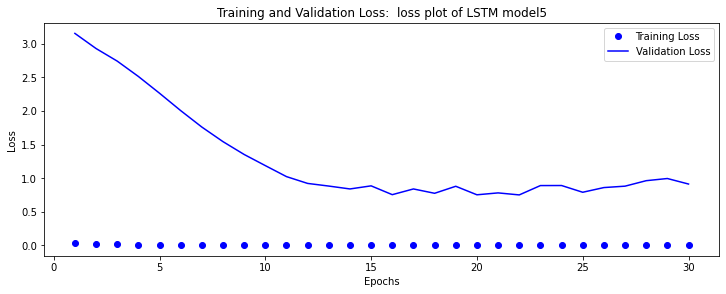

In [20]:
LSTM_model5 = models.Sequential()
LSTM_model5.add(layers.LSTM(50, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model5.add(layers.LSTM(50))


LSTM_model5.add(layers.Dense(1))

LSTM_model5.compile(optimizer=RMSprop(), loss='mse')
LSTM_model5_history = LSTM_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model5_history, "loss plot of LSTM model5")

Epoch 1/20
13/13 [==============================] - 10s 509ms/step - loss: 0.0781 - val_loss: 3.3650
Epoch 2/20
13/13 [==============================] - 5s 385ms/step - loss: 0.0188 - val_loss: 3.1263
Epoch 3/20
13/13 [==============================] - 4s 304ms/step - loss: 0.0164 - val_loss: 2.9420
Epoch 4/20
13/13 [==============================] - 4s 304ms/step - loss: 0.0145 - val_loss: 2.7902
Epoch 5/20
13/13 [==============================] - 5s 369ms/step - loss: 0.0135 - val_loss: 2.5932
Epoch 6/20
13/13 [==============================] - 5s 380ms/step - loss: 0.0125 - val_loss: 2.4040
Epoch 7/20
13/13 [==============================] - 4s 306ms/step - loss: 0.0104 - val_loss: 2.3095
Epoch 8/20
13/13 [==============================] - 5s 373ms/step - loss: 0.0100 - val_loss: 2.2378
Epoch 9/20
13/13 [==============================] - 6s 483ms/step - loss: 0.0103 - val_loss: 2.1556
Epoch 10/20
13/13 [==============================] - 4s 311ms/step - loss: 0.0086 - val_loss: 2.052

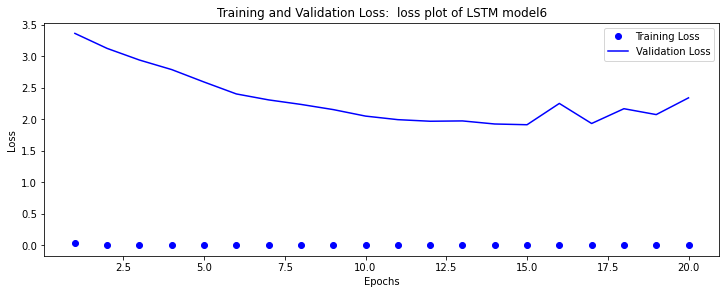

In [21]:
LSTM_model6 = models.Sequential()
LSTM_model6.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model6.add(layers.LSTM(50))


LSTM_model6.add(layers.Dense(1))

LSTM_model6.compile(optimizer=RMSprop(), loss='mse')
LSTM_model6_history = LSTM_model6.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model6_history, "loss plot of LSTM model6")

Epoch 1/30
13/13 [==============================] - 7s 289ms/step - loss: 0.0699 - val_loss: 4.0765
Epoch 2/30
13/13 [==============================] - 3s 242ms/step - loss: 0.0238 - val_loss: 3.9204
Epoch 3/30
13/13 [==============================] - 3s 242ms/step - loss: 0.0159 - val_loss: 3.8167
Epoch 4/30
13/13 [==============================] - 3s 235ms/step - loss: 0.0147 - val_loss: 3.6994
Epoch 5/30
13/13 [==============================] - 4s 312ms/step - loss: 0.0134 - val_loss: 3.5716
Epoch 6/30
13/13 [==============================] - 3s 243ms/step - loss: 0.0121 - val_loss: 3.4357
Epoch 7/30
13/13 [==============================] - 3s 237ms/step - loss: 0.0108 - val_loss: 3.2973
Epoch 8/30
13/13 [==============================] - 4s 282ms/step - loss: 0.0096 - val_loss: 3.1528
Epoch 9/30
13/13 [==============================] - 3s 256ms/step - loss: 0.0084 - val_loss: 2.9905
Epoch 10/30
13/13 [==============================] - 3s 235ms/step - loss: 0.0082 - val_loss: 2.7780

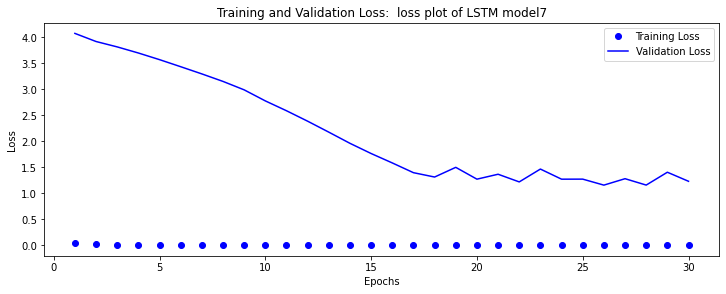

In [22]:
LSTM_model7 = models.Sequential()
LSTM_model7.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model7.add(layers.LSTM(32))


LSTM_model7.add(layers.Dense(1))

LSTM_model7.compile(optimizer=RMSprop(), loss='mse')
LSTM_model7_history = LSTM_model7.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model7_history, "loss plot of LSTM model7")

Epoch 1/20
13/13 [==============================] - 8s 361ms/step - loss: 0.1347 - val_loss: 3.9321
Epoch 2/20
13/13 [==============================] - 3s 247ms/step - loss: 0.0243 - val_loss: 3.8649
Epoch 3/20
13/13 [==============================] - 4s 351ms/step - loss: 0.0198 - val_loss: 3.8446
Epoch 4/20
13/13 [==============================] - 4s 327ms/step - loss: 0.0181 - val_loss: 3.8295
Epoch 5/20
13/13 [==============================] - 3s 253ms/step - loss: 0.0150 - val_loss: 3.7801
Epoch 6/20
13/13 [==============================] - 4s 295ms/step - loss: 0.0137 - val_loss: 3.7789
Epoch 7/20
13/13 [==============================] - 3s 256ms/step - loss: 0.0137 - val_loss: 3.7185
Epoch 8/20
13/13 [==============================] - 4s 318ms/step - loss: 0.0128 - val_loss: 3.6496
Epoch 9/20
13/13 [==============================] - 4s 288ms/step - loss: 0.0122 - val_loss: 3.5939
Epoch 10/20
13/13 [==============================] - 4s 292ms/step - loss: 0.0119 - val_loss: 3.5663

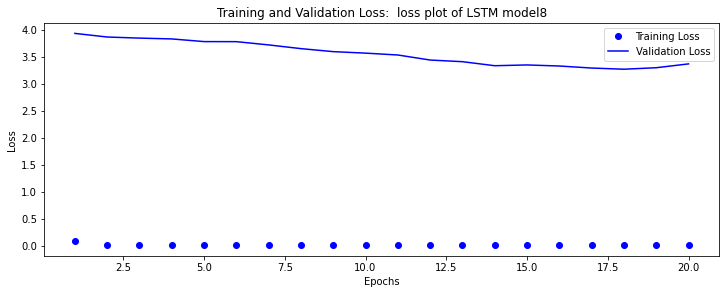

In [23]:
LSTM_model8 = models.Sequential()
LSTM_model8.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model8.add(layers.LSTM(32))


LSTM_model8.add(layers.Dense(1))

LSTM_model8.compile(optimizer=RMSprop(), loss='mse')
LSTM_model8_history = LSTM_model8.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model8_history, "loss plot of LSTM model8")

Epoch 1/30
13/13 [==============================] - 7s 295ms/step - loss: 0.0924 - val_loss: 4.2421
Epoch 2/30
13/13 [==============================] - 3s 205ms/step - loss: 0.0261 - val_loss: 4.0882
Epoch 3/30
13/13 [==============================] - 3s 215ms/step - loss: 0.0177 - val_loss: 3.9737
Epoch 4/30
13/13 [==============================] - 3s 217ms/step - loss: 0.0146 - val_loss: 3.8555
Epoch 5/30
13/13 [==============================] - 3s 216ms/step - loss: 0.0131 - val_loss: 3.7453
Epoch 6/30
13/13 [==============================] - 3s 206ms/step - loss: 0.0122 - val_loss: 3.6447
Epoch 7/30
13/13 [==============================] - 3s 214ms/step - loss: 0.0116 - val_loss: 3.5502
Epoch 8/30
13/13 [==============================] - 3s 208ms/step - loss: 0.0109 - val_loss: 3.4593
Epoch 9/30
13/13 [==============================] - 3s 206ms/step - loss: 0.0102 - val_loss: 3.3715
Epoch 10/30
13/13 [==============================] - 3s 212ms/step - loss: 0.0096 - val_loss: 3.2943

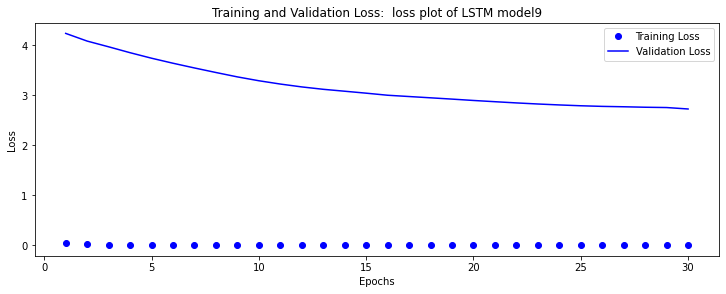

In [24]:
LSTM_model9 = models.Sequential()
LSTM_model9.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model9.add(layers.LSTM(16))


LSTM_model9.add(layers.Dense(1))

LSTM_model9.compile(optimizer=RMSprop(), loss='mse')
LSTM_model9_history = LSTM_model9.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model9_history, "loss plot of LSTM model9")

Epoch 1/20
13/13 [==============================] - 7s 267ms/step - loss: 0.0423 - val_loss: 2.8414
Epoch 2/20
13/13 [==============================] - 4s 297ms/step - loss: 0.0209 - val_loss: 2.7870
Epoch 3/20
13/13 [==============================] - 4s 291ms/step - loss: 0.0178 - val_loss: 2.7870
Epoch 4/20
13/13 [==============================] - 3s 227ms/step - loss: 0.0150 - val_loss: 2.8157
Epoch 5/20
13/13 [==============================] - 3s 231ms/step - loss: 0.0145 - val_loss: 2.8316
Epoch 6/20
13/13 [==============================] - 3s 236ms/step - loss: 0.0119 - val_loss: 2.8663
Epoch 7/20
13/13 [==============================] - 3s 236ms/step - loss: 0.0117 - val_loss: 2.8899
Epoch 8/20
13/13 [==============================] - 3s 253ms/step - loss: 0.0101 - val_loss: 2.9461
Epoch 9/20
13/13 [==============================] - 3s 239ms/step - loss: 0.0100 - val_loss: 2.9778
Epoch 10/20
13/13 [==============================] - 3s 229ms/step - loss: 0.0091 - val_loss: 3.0350

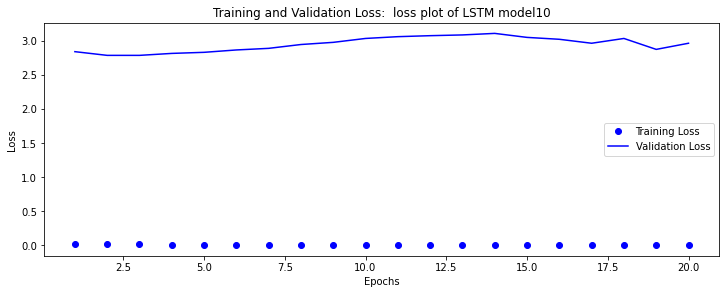

In [25]:
LSTM_model10 = models.Sequential()
LSTM_model10.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model10.add(layers.LSTM(16))


LSTM_model10.add(layers.Dense(1))

LSTM_model10.compile(optimizer=RMSprop(), loss='mse')
LSTM_model10_history = LSTM_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model10_history, "loss plot of LSTM model10")

Epoch 1/50
13/13 [==============================] - 7s 302ms/step - loss: 0.2567 - val_loss: 4.1139
Epoch 2/50
13/13 [==============================] - 3s 212ms/step - loss: 0.0476 - val_loss: 3.8955
Epoch 3/50
13/13 [==============================] - 4s 283ms/step - loss: 0.0156 - val_loss: 3.8636
Epoch 4/50
13/13 [==============================] - 3s 230ms/step - loss: 0.0122 - val_loss: 3.8663
Epoch 5/50
13/13 [==============================] - 3s 219ms/step - loss: 0.0116 - val_loss: 3.8550
Epoch 6/50
13/13 [==============================] - 3s 236ms/step - loss: 0.0102 - val_loss: 3.8378
Epoch 7/50
13/13 [==============================] - 3s 221ms/step - loss: 0.0100 - val_loss: 3.8235
Epoch 8/50
13/13 [==============================] - 3s 205ms/step - loss: 0.0104 - val_loss: 3.8065
Epoch 9/50
13/13 [==============================] - 3s 226ms/step - loss: 0.0095 - val_loss: 3.7857
Epoch 10/50
13/13 [==============================] - 3s 240ms/step - loss: 0.0097 - val_loss: 3.7706

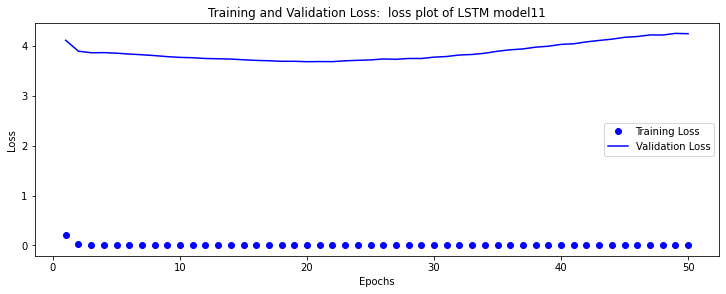

In [26]:
LSTM_model11 = models.Sequential()
LSTM_model11.add(layers.LSTM(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model11.add(layers.LSTM(5))


LSTM_model11.add(layers.Dense(1))

LSTM_model11.compile(optimizer=RMSprop(), loss='mse')
LSTM_model11_history = LSTM_model11.fit(train_dataset, epochs=50, validation_data=val_dataset)

plot_simple_loss(LSTM_model11_history, "loss plot of LSTM model11")

Epoch 1/20
13/13 [==============================] - 13s 619ms/step - loss: 0.1107 - val_loss: 3.8952
Epoch 2/20
13/13 [==============================] - 6s 496ms/step - loss: 0.0230 - val_loss: 3.8144
Epoch 3/20
13/13 [==============================] - 8s 601ms/step - loss: 0.0214 - val_loss: 3.6131
Epoch 4/20
13/13 [==============================] - 7s 497ms/step - loss: 0.0184 - val_loss: 3.4239
Epoch 5/20
13/13 [==============================] - 9s 636ms/step - loss: 0.0165 - val_loss: 3.1987
Epoch 6/20
13/13 [==============================] - 8s 658ms/step - loss: 0.0145 - val_loss: 2.9840
Epoch 7/20
13/13 [==============================] - 5s 427ms/step - loss: 0.0138 - val_loss: 2.6182
Epoch 8/20
13/13 [==============================] - 7s 550ms/step - loss: 0.0118 - val_loss: 2.2321
Epoch 9/20
13/13 [==============================] - 8s 587ms/step - loss: 0.0110 - val_loss: 1.7697
Epoch 10/20
13/13 [==============================] - 6s 444ms/step - loss: 0.0075 - val_loss: 1.683

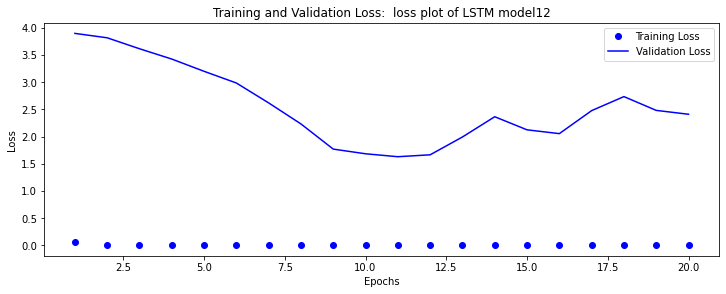

In [27]:
LSTM_model12 = models.Sequential()
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model12.add(layers.LSTM(50))


LSTM_model12.add(layers.Dense(1))

LSTM_model12.compile(optimizer=RMSprop(), loss='mse')
LSTM_model12_history = LSTM_model12.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model12_history, "loss plot of LSTM model12")

Epoch 1/20
13/13 [==============================] - 20s 791ms/step - loss: 0.0789 - val_loss: 3.8013
Epoch 2/20
13/13 [==============================] - 9s 665ms/step - loss: 0.0287 - val_loss: 3.7090
Epoch 3/20
13/13 [==============================] - 9s 686ms/step - loss: 0.0256 - val_loss: 3.6634
Epoch 4/20
13/13 [==============================] - 8s 628ms/step - loss: 0.0214 - val_loss: 3.5576
Epoch 5/20
13/13 [==============================] - 9s 748ms/step - loss: 0.0181 - val_loss: 3.5297
Epoch 6/20
13/13 [==============================] - 7s 540ms/step - loss: 0.0192 - val_loss: 3.5238
Epoch 7/20
13/13 [==============================] - 10s 759ms/step - loss: 0.0169 - val_loss: 3.3758
Epoch 8/20
13/13 [==============================] - 8s 586ms/step - loss: 0.0157 - val_loss: 3.2999
Epoch 9/20
13/13 [==============================] - 10s 769ms/step - loss: 0.0140 - val_loss: 3.1305
Epoch 10/20
13/13 [==============================] - 11s 842ms/step - loss: 0.0136 - val_loss: 2.

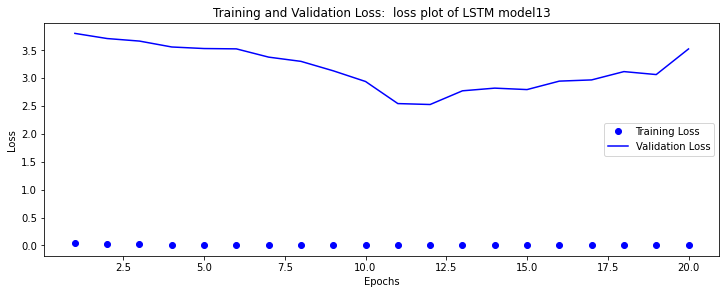

In [28]:
LSTM_model13 = models.Sequential()
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50))


LSTM_model13.add(layers.Dense(1))

LSTM_model13.compile(optimizer=RMSprop(), loss='mse')
LSTM_model13_history = LSTM_model13.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model13_history, "loss plot of LSTM model13")

Epoch 1/20
13/13 [==============================] - 9s 422ms/step - loss: 0.0635 - val_loss: 5.7310
Epoch 2/20
13/13 [==============================] - 4s 291ms/step - loss: 0.0336 - val_loss: 5.1116
Epoch 3/20
13/13 [==============================] - 4s 284ms/step - loss: 0.0213 - val_loss: 4.7680
Epoch 4/20
13/13 [==============================] - 4s 326ms/step - loss: 0.0172 - val_loss: 4.4569
Epoch 5/20
13/13 [==============================] - 4s 302ms/step - loss: 0.0149 - val_loss: 4.1322
Epoch 6/20
13/13 [==============================] - 4s 288ms/step - loss: 0.0128 - val_loss: 3.8611
Epoch 7/20
13/13 [==============================] - 4s 285ms/step - loss: 0.0117 - val_loss: 3.5470
Epoch 8/20
13/13 [==============================] - 4s 278ms/step - loss: 0.0104 - val_loss: 3.2677
Epoch 9/20
13/13 [==============================] - 4s 282ms/step - loss: 0.0095 - val_loss: 2.9599
Epoch 10/20
13/13 [==============================] - 4s 272ms/step - loss: 0.0086 - val_loss: 2.6927

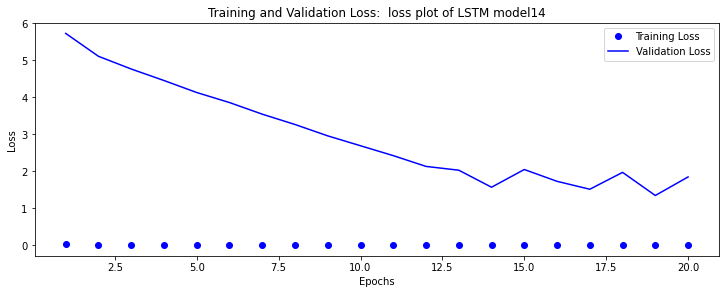

In [29]:
LSTM_model14 = models.Sequential()
LSTM_model14.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model14.add(layers.LSTM(32))


LSTM_model14.add(layers.Dense(1))

LSTM_model14.compile(optimizer=RMSprop(), loss='mse')
LSTM_model14_history = LSTM_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model14_history, "loss plot of LSTM model14")

Epoch 1/40
13/13 [==============================] - 6s 276ms/step - loss: 0.0678 - val_loss: 4.5519
Epoch 2/40
13/13 [==============================] - 3s 203ms/step - loss: 0.0169 - val_loss: 4.4971
Epoch 3/40
13/13 [==============================] - 3s 214ms/step - loss: 0.0125 - val_loss: 4.4666
Epoch 4/40
13/13 [==============================] - 3s 202ms/step - loss: 0.0107 - val_loss: 4.4486
Epoch 5/40
13/13 [==============================] - 3s 203ms/step - loss: 0.0097 - val_loss: 4.4399
Epoch 6/40
13/13 [==============================] - 3s 265ms/step - loss: 0.0091 - val_loss: 4.4399
Epoch 7/40
13/13 [==============================] - 3s 199ms/step - loss: 0.0085 - val_loss: 4.4487
Epoch 8/40
13/13 [==============================] - 3s 193ms/step - loss: 0.0079 - val_loss: 4.4646
Epoch 9/40
13/13 [==============================] - 3s 197ms/step - loss: 0.0073 - val_loss: 4.4841
Epoch 10/40
13/13 [==============================] - 3s 267ms/step - loss: 0.0067 - val_loss: 4.5033

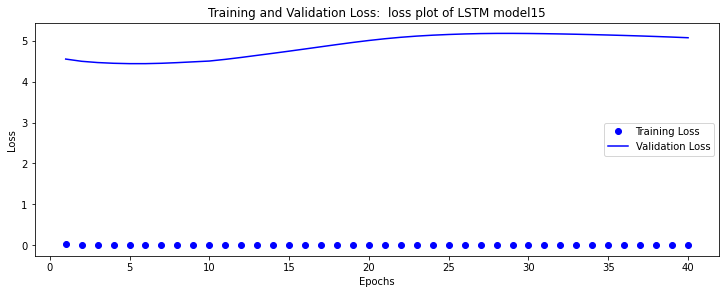

In [30]:
LSTM_model15 = models.Sequential()
LSTM_model15.add(layers.LSTM(16, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model15.add(layers.LSTM(16))


LSTM_model15.add(layers.Dense(1))

LSTM_model15.compile(optimizer=RMSprop(), loss='mse')
LSTM_model15_history = LSTM_model15.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(LSTM_model15_history, "loss plot of LSTM model15")

Epoch 1/20
13/13 [==============================] - 9s 442ms/step - loss: 0.1102 - val_loss: 4.3028
Epoch 2/20
13/13 [==============================] - 6s 473ms/step - loss: 0.0247 - val_loss: 4.2039
Epoch 3/20
13/13 [==============================] - 5s 407ms/step - loss: 0.0223 - val_loss: 3.8633
Epoch 4/20
13/13 [==============================] - 5s 385ms/step - loss: 0.0178 - val_loss: 3.5352
Epoch 5/20
13/13 [==============================] - 4s 322ms/step - loss: 0.0154 - val_loss: 3.2302
Epoch 6/20
13/13 [==============================] - 5s 354ms/step - loss: 0.0136 - val_loss: 2.9348
Epoch 7/20
13/13 [==============================] - 5s 421ms/step - loss: 0.0117 - val_loss: 2.7272
Epoch 8/20
13/13 [==============================] - 5s 375ms/step - loss: 0.0111 - val_loss: 2.4539
Epoch 9/20
13/13 [==============================] - 5s 400ms/step - loss: 0.0092 - val_loss: 2.1784
Epoch 10/20
13/13 [==============================] - 4s 337ms/step - loss: 0.0088 - val_loss: 1.8217

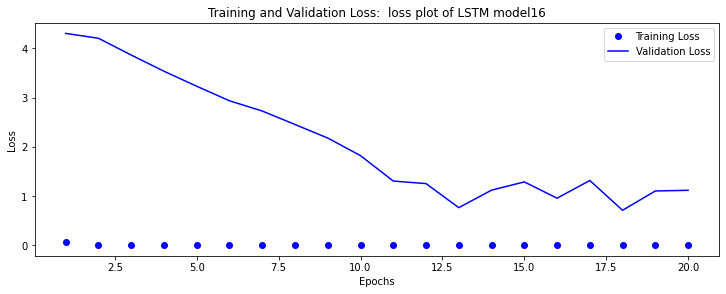

In [31]:
LSTM_model16 = models.Sequential()
LSTM_model16.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model16.add(layers.LSTM(64))


LSTM_model16.add(layers.Dense(1))

LSTM_model16.compile(optimizer=RMSprop(), loss='mse')
LSTM_model16_history = LSTM_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model16_history, "loss plot of LSTM model16")

Epoch 1/30
13/13 [==============================] - 14s 581ms/step - loss: 0.0739 - val_loss: 4.2398
Epoch 2/30
13/13 [==============================] - 5s 404ms/step - loss: 0.0286 - val_loss: 4.1125
Epoch 3/30
13/13 [==============================] - 5s 396ms/step - loss: 0.0223 - val_loss: 3.9895
Epoch 4/30
13/13 [==============================] - 5s 388ms/step - loss: 0.0201 - val_loss: 3.8754
Epoch 5/30
13/13 [==============================] - 5s 417ms/step - loss: 0.0188 - val_loss: 3.7708
Epoch 6/30
13/13 [==============================] - 5s 390ms/step - loss: 0.0178 - val_loss: 3.6808
Epoch 7/30
13/13 [==============================] - 5s 390ms/step - loss: 0.0168 - val_loss: 3.5953
Epoch 8/30
13/13 [==============================] - 7s 523ms/step - loss: 0.0157 - val_loss: 3.4999
Epoch 9/30
13/13 [==============================] - 6s 485ms/step - loss: 0.0144 - val_loss: 3.3806
Epoch 10/30
13/13 [==============================] - 5s 420ms/step - loss: 0.0128 - val_loss: 3.195

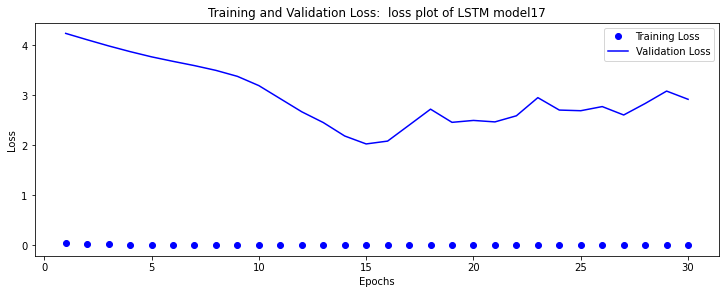

In [32]:
LSTM_model17 = models.Sequential()
LSTM_model17.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32))


LSTM_model17.add(layers.Dense(1))

LSTM_model17.compile(optimizer=RMSprop(), loss='mse')
LSTM_model17_history = LSTM_model17.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model17_history, "loss plot of LSTM model17")

Epoch 1/30
13/13 [==============================] - 10s 415ms/step - loss: 0.0379 - val_loss: 3.3783
Epoch 2/30
13/13 [==============================] - 4s 302ms/step - loss: 0.0237 - val_loss: 3.2867
Epoch 3/30
13/13 [==============================] - 4s 327ms/step - loss: 0.0178 - val_loss: 3.2780
Epoch 4/30
13/13 [==============================] - 5s 374ms/step - loss: 0.0154 - val_loss: 3.2995
Epoch 5/30
13/13 [==============================] - 5s 390ms/step - loss: 0.0141 - val_loss: 3.3289
Epoch 6/30
13/13 [==============================] - 4s 304ms/step - loss: 0.0131 - val_loss: 3.3627
Epoch 7/30
13/13 [==============================] - 5s 368ms/step - loss: 0.0122 - val_loss: 3.3965
Epoch 8/30
13/13 [==============================] - 4s 304ms/step - loss: 0.0112 - val_loss: 3.4177
Epoch 9/30
13/13 [==============================] - 4s 308ms/step - loss: 0.0104 - val_loss: 3.4133
Epoch 10/30
13/13 [==============================] - 4s 311ms/step - loss: 0.0107 - val_loss: 3.304

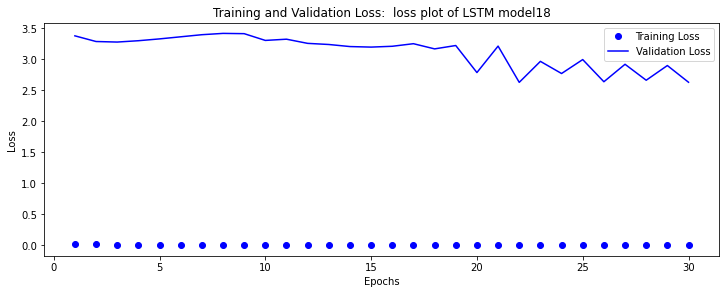

In [33]:
LSTM_model18 = models.Sequential()
LSTM_model18.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model18.add(layers.LSTM(32, return_sequences=True))
LSTM_model18.add(layers.LSTM(32))


LSTM_model18.add(layers.Dense(1))

LSTM_model18.compile(optimizer=RMSprop(), loss='mse')
LSTM_model18_history = LSTM_model18.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model18_history, "loss plot of LSTM model18")

In [34]:
histories = [LSTM_model1_history, LSTM_model2_history, LSTM_model3_history, LSTM_model4_history, LSTM_model5_history, LSTM_model6_history, LSTM_model7_history, LSTM_model8_history, LSTM_model9_history, LSTM_model10_history, LSTM_model11_history, LSTM_model12_history, LSTM_model13_history, LSTM_model14_history, LSTM_model15_history, LSTM_model16_history, LSTM_model17_history, LSTM_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 0.40379875898361206, epoch: 9
Model 2: min val loss: 0.28473085165023804, epoch: 20
Model 3: min val loss: 0.4348827600479126, epoch: 11
Model 4: min val loss: 0.418510377407074, epoch: 14
Model 5: min val loss: 0.7510513067245483, epoch: 22
Model 6: min val loss: 1.9153923988342285, epoch: 15
Model 7: min val loss: 1.1579699516296387, epoch: 26
Model 8: min val loss: 3.2682347297668457, epoch: 18
Model 9: min val loss: 2.729170799255371, epoch: 30
Model 10: min val loss: 2.786999225616455, epoch: 3
Model 11: min val loss: 3.684246063232422, epoch: 20
Model 12: min val loss: 1.6299387216567993, epoch: 11
Model 13: min val loss: 2.526700735092163, epoch: 12
Model 14: min val loss: 1.3479945659637451, epoch: 19
Model 15: min val loss: 4.439854621887207, epoch: 5
Model 16: min val loss: 0.7122740149497986, epoch: 18
Model 17: min val loss: 2.0285565853118896, epoch: 15
Model 18: min val loss: 2.6284737586975098, epoch: 22
